In [1]:
# # this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


# OLTraj Example 1: Plotting Lagrangian trajectories along a cruise track

## Objective
Given a ship track (in UTC_time, latitude and longitude), extract and plot trajectories (backward and forward) along the track. 

## Input data: 
Cruise track (included in the Input directory)


## Code:

### Import needed modules

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import pandas as pd

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point


### Read cruise track

In [10]:
## this input file shoud look like this (it's important to keep the same exact names for the column labels):
## (Note also that the DateTime field is in UTC)
# DateTime_UTC,Latitude_degreesN,Longitude_degreesE
# 2017-09-23  17:46,50.06083333,-3.343666667
# 2017-09-24  11:21,48.92683333,-7.6235
# 2017-09-25  03:57,47.269,-11.01
# 2017-09-25  12:04,46.68633333,-12.00016667
# ...

track = pd.read_csv("../Input/cruise_track.csv")
track['DateTime_UTC'] = pd.to_datetime(track['DateTime_UTC']) 

track['DateTime_UTC'] = track['DateTime_UTC'] - pd.Timedelta(days = 365*6) # remove this when v2.2 is all loaded

# remove some of the stations to speed the example up
track = track.iloc[0::3,:]

### Extract OLTraj trajectories corresponding to cruise track

In [4]:
# intialise arrays that will store the trajectories
trajlon = np.full((len(track), 59), np.nan)
trajlat = np.full((len(track), 59), np.nan)

OLTraj_THREDDS_string = 'http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/'

for ifn in range(len(track)):   
    fname = track['DateTime_UTC'].iloc[ifn].strftime('%Y')+'/'+track['DateTime_UTC'].iloc[ifn].strftime('%Y%m%d') + '_oltraj_uv_global.nc'
    fn = OLTraj_THREDDS_string + fname
    
    print("Reading OLTraj file: " + fn )

    # open OLTraj file
    dsAV = xr.open_dataset(fn)

    # read OLTraj trajectories corresponding to current location of the cruise track 
    tmp = dsAV.sel(lon=track['Longitude_degreesE'].iloc[ifn], lat=track['Latitude_degreesN'].iloc[ifn], method="nearest")

    # store trajectories for given date
    trajlon[ifn] = tmp['trajlon']
    trajlat[ifn] = tmp['trajlat']



Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/20110925_oltraj_uv_global.nc
Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/20110927_oltraj_uv_global.nc
Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/20110929_oltraj_uv_global.nc
Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/20110930_oltraj_uv_global.nc
Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/20111002_oltraj_uv_global.nc
Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/20111004_oltraj_uv_global.nc
Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/20111005_oltraj_uv_global.nc
Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/20111006_oltraj_uv_global.nc
Reading OLTraj file: http://dap.ceda.ac.uk/thredds/dodsC/neodc/oltraj/data/v2.2/2011/201

### Plot cruise track and Lagrangian trajectories at each station along the track

<ipython-input-71-5655f7431578>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(track['DateTime_UTC'].dt.dayofyear.values, color="w", fontsize=14)


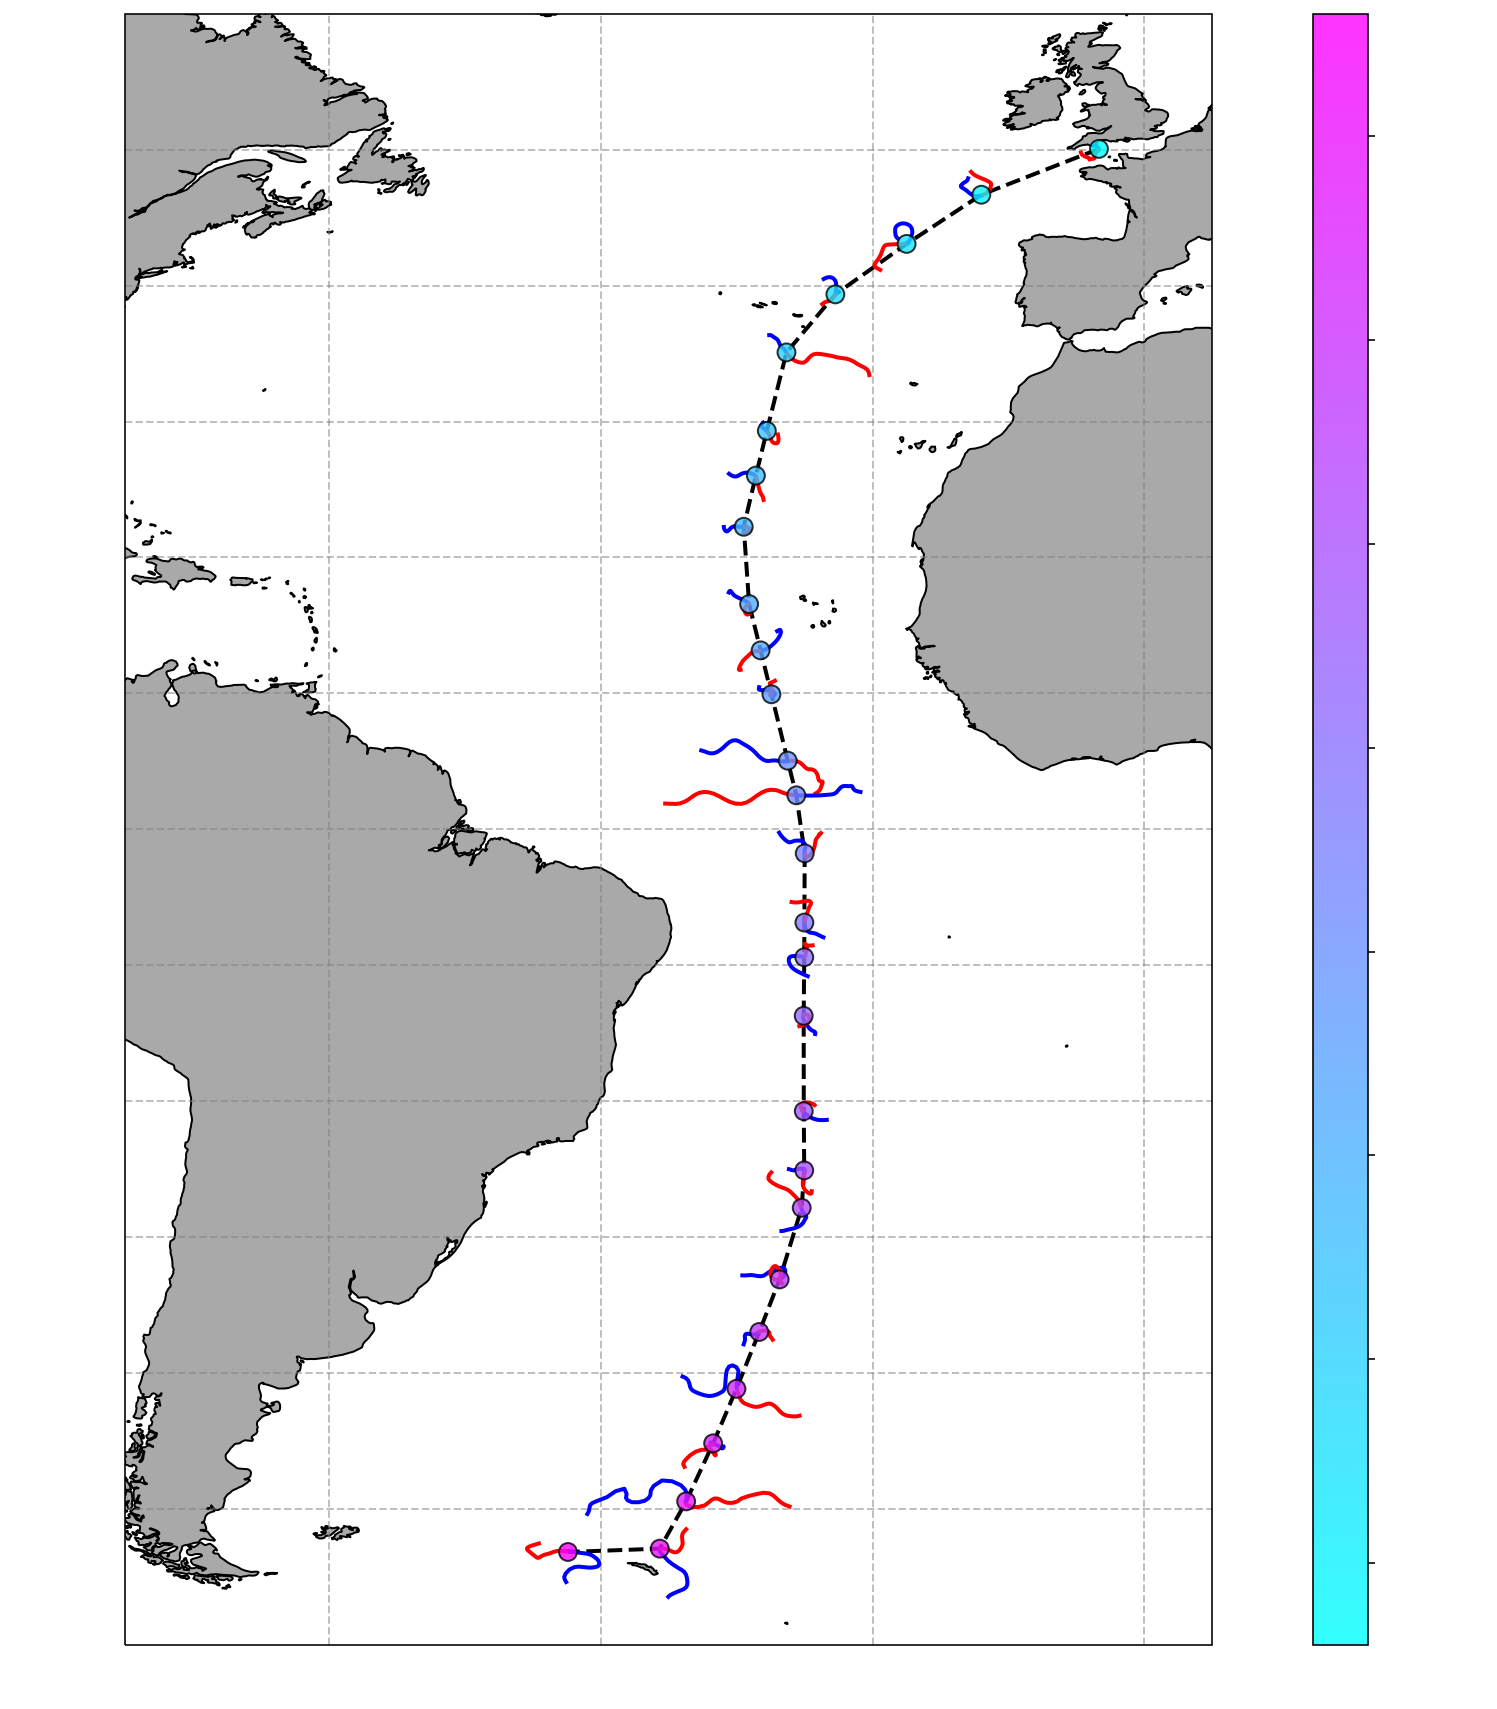

In [71]:
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# initialise figure
fig = plt.figure(figsize=(40,15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=-25) )

# plot cruise track
ax.plot(  track['Longitude_degreesE'], track['Latitude_degreesN'], transform=ccrs.PlateCarree(), lw=2, color='k', ls='--', ms=10 )
pc = ax.scatter(  track['Longitude_degreesE'], track['Latitude_degreesN'], s=80, c=track['DateTime_UTC'].dt.dayofyear.values, cmap=cm.get_cmap('cool'), edgecolors='k', transform=ccrs.PlateCarree(), zorder=60, alpha=0.8 )

# plot colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('day of the year', color="w", fontsize=20)
cb.ax.set_yticklabels(track['DateTime_UTC'].dt.dayofyear.values, color="w", fontsize=14)

# plot Lagrangian trajectories
for it in range(len(trajlon)):
    # backward trajectories
    ax.plot(trajlon[it, :30], trajlat[it, :30], color='b', linestyle='-', lw=2, transform=ccrs.PlateCarree(), zorder=10 )
    # forward trajectories
    ax.plot(trajlon[it, 30:], trajlat[it, 30:], color='r', linestyle='-', lw=2, transform=ccrs.PlateCarree(), zorder=10 )

# add continents
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='darkgray'))

# set geographical extent of figure
ax.set_extent([-75, 5, -60, 60], ccrs.PlateCarree())


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-60, -40, -20, 0])
gl.ylocator = mticker.FixedLocator(np.arange(-60,60,10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'fontsize': 20, 'color': 'w'}
gl.xlabel_style = {'fontsize': 20, 'color': 'w'}

The blue and red lines represent the backward and forward trajectories sampled during each station (black circles) along the the cruise track (dashed black line).